# Generating Elon Musk Tweets Using GPT-2
### IMPORTANT: This notebook was made by [ajay19](https://www.kaggle.com/ajay19) and his original work can be found [here](https://www.kaggle.com/ajay19/transformers-tweet-generation/comments), I applied his notebook to the dataset I collected because I wanted to mess around with transformers for a bit, have fun!.
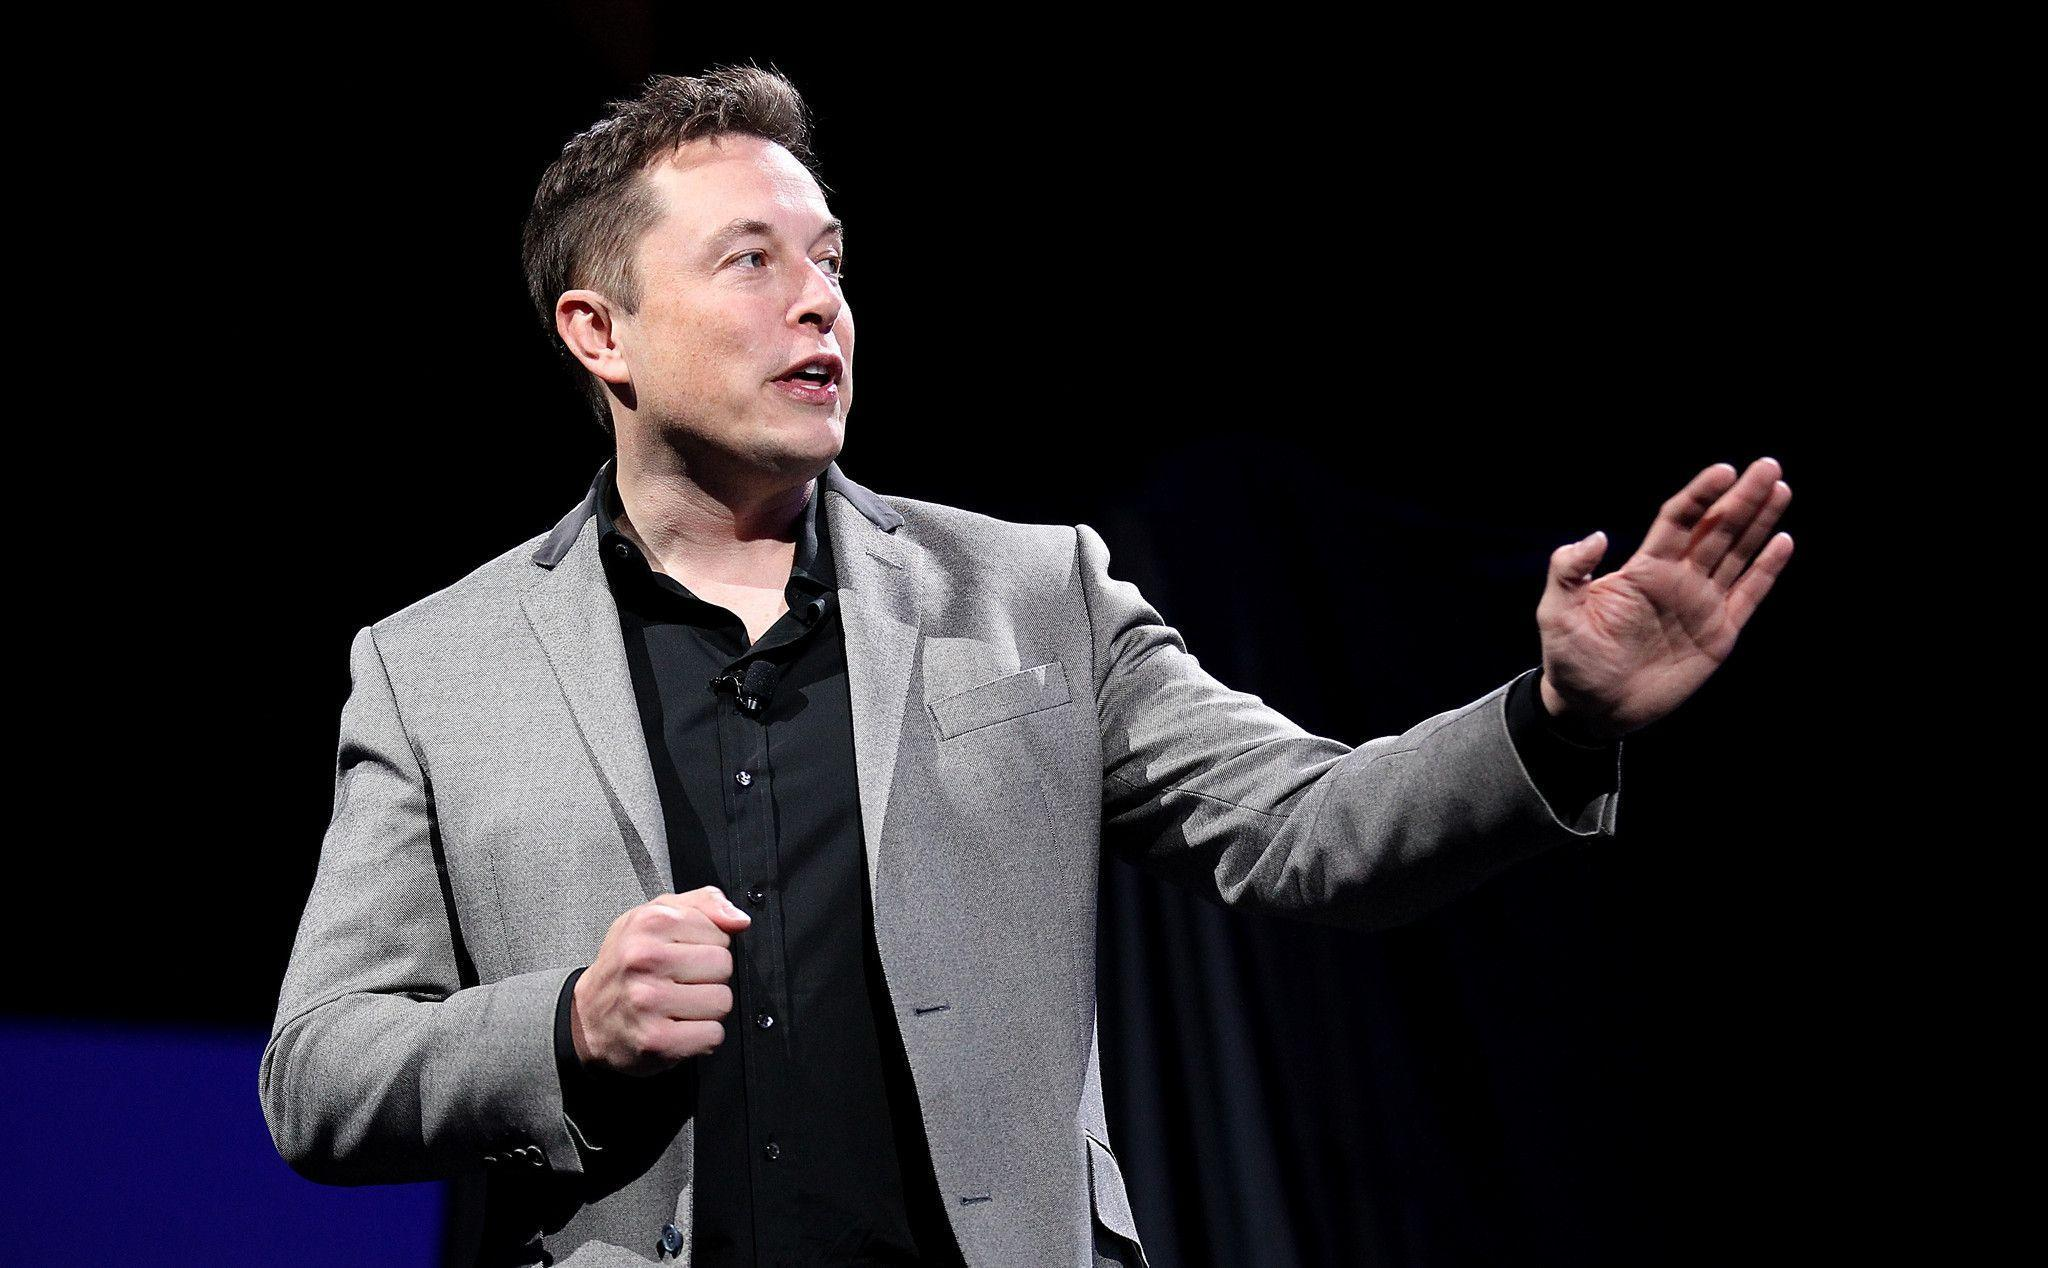

1. Preparations
    1. Importing the necessary libraries
    2. Importing the data
2. Data
    1. Preprocessing the text
3. GPT-2
    1. Training
    2. Testing
# 1. Preparations
## 1.1. Importing the necessary libraries for data loading

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re

## 1.2. Importing the data
### The data is organized in 12 .csv files, I loaded each one independently and then concatenated all of them into a single dataframe.

In [ ]:
_1 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2010.csv')
_2 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2011.csv')
_3 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2012.csv')
_4 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2013.csv')
_5 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2014.csv')
_6 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2015.csv')
_7 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2016.csv')
_8 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2017.csv')
_9 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2018.csv')
_10 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2019.csv')
_11 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2020.csv')
_12 = pd.read_csv('../input/elon-musk-tweets-2010-2021/2021.csv')

In [ ]:
full_df = pd.concat([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12], axis = 0)

### Take a quick look at the data

In [ ]:
pd.set_option("display.max_columns", 50) # So all columns are shown
full_df.head()

In [ ]:
full_df.info()

### We only need the tweets themselves and can get rid of all of the metadata, so I saved the tweets in a single variable and deleted the rest of the dataframe

In [ ]:
tweets = full_df['tweet']
del full_df

# 2. Data
## 2.1 Preprocessing the text
### In order to handle the raw text data, we should first preprocess it, when doing transfer-learning you should always pre-process the data in the same way it was processed when the model was first trained, so we'll use the GPT2Tokenizer class from transformers and define the tokens.
### Add three new tokens in the pre-trained GPT2 tokenizer: \ <|sos|> : start of sentence \ <|eos|> : end of sentence \ <|pad|> : padding token

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|sos|>', 
                                          eos_token='<|eos|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

In [ ]:
max_tweet = max([len(tokenizer.encode(tweet)) for tweet in tweets])

print(f'The longest tweet is {max_tweet} tokens long.')

# GPT-2
## Training
## What is GPT-2 and why do we use it?
### GPT-2 Is a transformer-based architecture NN that was trained on a massive amount of unlabeled raw text data in a self-supervised fashion in order to predict the next word in a given sentence, and the attempts at using it in a transfer-learning manner have been very successful so far. <br />  <br /> You can use it yourself to create models that do anything from answering questions, generating stories, to mimicing someone on Twitter- which we're going to do here.
#### Next we create a custom dataloader for our tweets using torch Dataset. \ Each entry in the dataset will be two tensors, one which is the encoding for the string and one which is the attention mask

In [ ]:
batch_size = 32

import torch
from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self,tweets,tokenizer,gpt2_type="gpt2",max_length=max_tweet):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attention_masks = []
        
        for tweet in tweets:
            encoding_dict = tokenizer('<|sos|>'+ tweet +'<|eos|>',truncation=True,
                                     max_length=max_length,
                                     padding='max_length')
            
            self.input_ids.append(torch.tensor(encoding_dict['input_ids']))
            self.attention_masks.append(torch.tensor(encoding_dict['attention_mask']))
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx], self.attention_masks[idx]

In [ ]:
from torch.utils.data import random_split
dataset = TweetDataset(tweets,tokenizer,max_length=max_tweet)

In [ ]:
train_size = int(0.9 * len(dataset)) #90% train, 10% validation
val_size = len(dataset)-train_size

train,val = random_split(dataset,[train_size,val_size])
print(f'No of train samples = {train_size} and Number of validation samples = {val_size}')

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(train,sampler = RandomSampler(train),
                             batch_size = batch_size)

val_dataloader = DataLoader(val,sampler = SequentialSampler(val),
                           batch_size = batch_size)

In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

### The time for training will depend on the number of samples divided by the batch size, then multiplied by the epochs, I encourage people to expirement with hyperparameters such as batch size, epochs, learning rate, LR scheduling and optimizers, and compare results. <br />
### I'm only going to use 3 epochs for now, I recommend doing at least 5-6 if you want good results.

In [ ]:
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 3
warmup_steps = 1e2
sample_every = 100

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
xt = [i for i in range(1,epochs+1)]
plt.xticks(xt)

plt.show()


## 2.2. Testing
#### Evaluate the model by changing the prompt below and manually inspecting the results, have fun!

In [ ]:
import os
out_dir = '/ElonTweets'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained('./')
tokenizer.save_pretrained('./')

### Example outputs, manually testing the model.

In [ ]:
model.eval()

prompt = "<|sos|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

In [ ]:
#Load Saved Model

model = GPT2LMHeadModel.from_pretrained('./')
tokenizer = GPT2Tokenizer.from_pretrained('./')
model.to(device)

In [ ]:
test_tweet = 'Why would I ever'

In [ ]:
def generateTweets(prompt, n_return):
    model.eval()

    prompt = prompt

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = model.generate(
                                    generated, 
                                    do_sample=True,   
                                    top_k=500, 
                                    max_length = 300,
                                    top_p=0.95, 
                                    num_return_sequences=n_return
                                    )

    for i, sample_output in enumerate(sample_outputs):
        print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

In [ ]:
generateTweets(test_tweet, 3)

In [ ]:
test_tweet = 'Tesla is going to'

In [ ]:
generateTweets(test_tweet, 3)

##### END 